# Projet

In [2]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

import glob
import torch 
import librosa
from os import listdir
import re
import audioread

import glob
import re
import librosa
import numpy as np

import torch
import torchaudio
import numpy as np


## Préparation des données

### Labels

In [3]:
dict_classes = {
    0: 'portuguese',
    1: 'china',
    2: 'french',
    3: 'quebec',
    4: 'maroc',
    5: 'japon',
    6: 'american',
    7: 'english',
    8: 'korean',
    9: 'spain',
    10: 'italy',
    11: 'tunis'
    }

dict_classes_inv = {
    'portuguese': 0,
    'china': 1,
    'french': 2,
    'quebec': 3,
    'maroc': 4,
    'japon': 5,
    'american': 6,
    'english': 7,
    'korean': 8,
    'spain': 9,
    'italy': 10,
    'tunis': 11
    }
    
list_genres = ['M', 'F']

Spectogrammes transformations

In [4]:
def frequency_masking(x, max_width=30):
    """
    Applique un masquage de fréquences sur les spectrogrammes.
    """
    _, num_freq, num_time = x.size()
    mask_width = torch.randint(0, max_width, (1,)).item()
    f0 = torch.randint(0, num_freq - mask_width, (1,)).item()
    x[ :, f0:f0 + mask_width, :] = 0
    return x

def time_masking(x, max_width=20):
    """
    Applique un masquage temporel sur les spectrogrammes.
    """
    _, num_freq, num_time = x.size()
    mask_width = torch.randint(0, max_width, (1,)).item()
    t0 = torch.randint(0, num_time - mask_width, (1,)).item()
    x[:, :, t0:t0 + mask_width] = 0
    return x

def time_shifting(x, shift_max=5):
    """
    Décale les spectrogrammes horizontalement dans le temps.
    """
    shift = torch.randint(-shift_max, shift_max + 1, (1,)).item()
    if shift > 0:
        x = torch.cat([x[ :, :, shift:], x[ :, :, :shift]], dim=2)
    elif shift < 0:
        x = torch.cat([x[ :, :, shift:], x[:, :, :shift]], dim=2)
    return x

### Datasets

In [5]:
from torch.utils.data import Dataset, DataLoader


class AudioDataset(Dataset):
    def __init__(self, mode, transform=None):

        self.names = []
        self.transform = transform
        self.mode = mode
        
        for file in glob.glob(f'spectrograms_clips/*.npy'):
            number = int(file.split('.')[0].split('_')[-1])
            if mode == "train":
                if number <= 40:
                    self.names.append(file)
            elif mode == "validation":
                if 41 <= number <= 45:
                    self.names.append(file)
            elif mode == "test":
                if 46 <= number:
                    self.names.append(file)


    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        data = np.load(self.names[idx]).astype(np.float32)

        langue = self.names[idx].split('/')[-1].split('.')[0].split('_')[0]
        labels = dict_classes_inv[langue]
        data = torch.tensor(data)

        if self.transform:
            # passer data en 3 canaux
            data = data.unsqueeze(0)
            data = torch.cat((data, data, data), 0)
            
            if self.mode == "train":
                data = frequency_masking(data)
                data = time_masking(data)
                data = time_shifting(data)
            data = transforms.ToPILImage()(data)
            data = self.transform(data)

        return data, torch.tensor(labels, dtype=torch.long)

### Transformations

In [6]:
from torchvision import transforms


data_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),        
    # transforms.RandomVerticalFlip(p=0.2),          
    transforms.RandomRotation(degrees=5),         
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),               
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),                         
    transforms.Normalize(mean=[0.5], std=[0.5])   
    ])


test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),                         
    transforms.Normalize(mean=[0.5], std=[0.5])   
    ])


In [7]:
train_dataset = AudioDataset(mode='train', transform=data_transforms)
val_dataset = AudioDataset(mode='validation', transform=test_transforms)
test_dataset = AudioDataset(mode='test', transform=test_transforms)

### Exemples

In [8]:
print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
print(f"Taille du dataset de validation : {len(val_dataset)}")
print(f"Taille du dataset de test : {len(test_dataset)}")

Taille du dataset d'entraînement : 960
Taille du dataset de validation : 120
Taille du dataset de test : 120


torch.Size([3, 224, 224])
tensor(1)


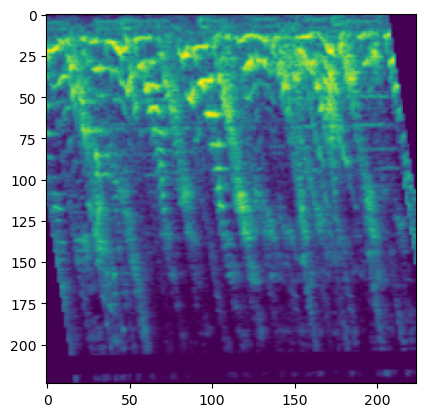

In [9]:
# afficher un exemple
data, label = train_dataset.__getitem__(0)
print(data.shape)
print(label)
plt.imshow(data[0], cmap='viridis')
plt.show()

spectro_shape = data.shape


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4)

## Modèles

### LeNet

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Définir le modèle LeNet
class LeNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.num_channels, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1_input_size = self._calculate_fc1_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

    def _calculate_fc1_input_size(self):
        with torch.no_grad():  # Pas besoin de gradients pou164r cette étape
            x = torch.randn(1, self.num_channels, 224, 224)  # Exemple d'entrée
            x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
            x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        return x.numel()  # Total des éléments dans le tenseur

    def forward(self, x, training=True):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.fc1_input_size)  # Aplatir
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)  # Dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialiser le modèle
spectro_shape = (224, 224)  # Taille des spectrogrammes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet(num_channels=3, num_classes=12).to(device)  # Placer le modèle sur l'appareil

# Résumé du modèle avec torchsummary
print(f"Spectrogram shape: {spectro_shape}")
summary(model, (3, spectro_shape[0], spectro_shape[1]))


Spectrogram shape: (224, 224)
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 224, 224]         456
├─Conv2d: 1-2                            [-1, 16, 108, 108]        2,416
├─Linear: 1-3                            [-1, 120]                 5,598,840
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 12]                  1,020
Total params: 5,612,896
Trainable params: 5,612,896
Non-trainable params: 0
Total mult-adds (M): 56.18
Input size (MB): 0.57
Forward/backward pass size (MB): 3.72
Params size (MB): 21.41
Estimated Total Size (MB): 25.71


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 224, 224]         456
├─Conv2d: 1-2                            [-1, 16, 108, 108]        2,416
├─Linear: 1-3                            [-1, 120]                 5,598,840
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 12]                  1,020
Total params: 5,612,896
Trainable params: 5,612,896
Non-trainable params: 0
Total mult-adds (M): 56.18
Input size (MB): 0.57
Forward/backward pass size (MB): 3.72
Params size (MB): 21.41
Estimated Total Size (MB): 25.71

### ResNet18 pré entrainé

In [21]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary


# Charger le modèle ResNet18 pré-entraîné
base_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# Congeler les couches du modèle de base
for param in base_model.parameters():
    param.requires_grad = False

# Modifier le modèle pour personnaliser les couches de sortie
# Remplacer le classificateur final
class CustomResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # Réutiliser le modèle de base sans la couche fully connected 
        self.base = nn.Sequential(*list(base_model.children())[:-1])
        # Ajouter des couches personnalisées après la couche globale d'agrégation
        self.custom_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 12)
        )

    def forward(self, x, *args, **kwargs):
        x = self.base(x)
        x = self.custom_layers(x)
        return x

model = CustomResNet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(summary(model, (3, spectro_shape[0], spectro_shape[1])))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 2, 112]          (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 2, 112]          (128)
|    └─ReLU: 2-3                         [-1, 64, 2, 112]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 1, 56]           --
|    └─Sequential: 2-5                   [-1, 64, 1, 56]           --
|    |    └─BasicBlock: 3-1              [-1, 64, 1, 56]           (73,984)
|    |    └─BasicBlock: 3-2              [-1, 64, 1, 56]           (73,984)
|    └─Sequential: 2-6                   [-1, 128, 1, 28]          --
|    |    └─BasicBlock: 3-3              [-1, 128, 1, 28]          (230,144)
|    |    └─BasicBlock: 3-4              [-1, 128, 1, 28]          (295,424)
|    └─Sequential: 2-7                   [-1, 256, 1, 14]          --
|    |    └─BasicBlock: 3-5              [-1, 256, 

## VGG 16 pré entrainé

In [14]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

# Charger VGG16 pré-entraîné
base_model = models.vgg16(pretrained=True)

# Geler les poids de la base convolutive
for param in base_model.features.parameters():
    param.requires_grad = False

# Adapter la dernière couche pour votre nombre de classes
num_classes = 12  # Par exemple, 12 langues
base_model.classifier[6] = nn.Linear(base_model.classifier[6].in_features, num_classes)

# Modèle final personnalisé
class CustomVGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = base_model.classifier

    def forward(self, x, training=True):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Rend plat
        x = nn.Dropout(0.5)(x)
        x = self.classifier(x)
        return x

model = CustomVGG16()

# Transférer sur le bon périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Résumé du modèle
spectro_shape = (3, 224, 224)  # Exemple avec des spectrogrammes de taille 224x224
print(summary(model, input_size=spectro_shape))


/home/n7student/miniforge3/envs/opti_sto/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/n7student/miniforge3/envs/opti_sto/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

### Modèle pré entrainé sur des spectres

In [15]:
from transformers import ViTModel, ViTConfig
import torch
import torch.nn as nn
from torchsummary import summary


class CustomViT(nn.Module):
    def __init__(self, num_classes=12, image_size=(224, 224)):
        super().__init__()
        config = ViTConfig.from_pretrained(
            "google/vit-base-patch16-224-in21k", 
            num_channels=3,  
            image_size=image_size,  
        )
        self.vit = ViTModel(config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, x, *args, **kwargs):
        outputs = self.vit(pixel_values=x)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)

image_size = (224, 224) 
num_classes = 12  
model = CustomViT(num_classes=num_classes, image_size=image_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

input_tensor = torch.rand(1, 3, 224, 224).to(device)
output = model(input_tensor)
print("Output shape:", output.shape)  


2024-12-23 18:41:13.732186: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 18:41:13.733553: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-23 18:41:13.754310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

## Entrainement

In [24]:
from tqdm import tqdm

nb_epochs = 60

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

#cosine annealing learning rate
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nb_epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(nb_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for data, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{nb_epochs}"):
        data, labels = data.to(device), labels.to(device)
        labels = torch.eye(12, device=labels.device)[labels].to(labels.device)
        optimizer.zero_grad()
        outputs = model(data.float(), training=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        outputs = nn.functional.softmax(outputs, dim=1)
        predicted = torch.argmax(outputs, axis=1)
        labels = torch.argmax(labels, axis=1)
        correct += torch.sum(predicted == labels).item()
    
    train_losses.append(train_loss / (len(train_dataloader)))
    train_accuracies.append(100 * correct / (len(train_dataloader)* train_dataloader.batch_size))

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in tqdm(val_dataloader, desc=f"Validation {epoch+1}/{nb_epochs}"):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data.float(), training=False)
            labels = torch.eye(12, device=labels.device)[labels].to(labels.device)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            outputs = nn.functional.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, axis=1)
            labels = torch.argmax(labels, axis=1)
            correct += torch.sum(predicted == labels).item()
    
    val_losses.append(val_loss / (len(val_dataloader)))
    val_accuracies.append(100 * correct / (len(val_dataloader)* val_dataloader.batch_size))

    # sauvegarder le modèle si l'accruacy de validation est meilleure
    if val_accuracies[-1] == max(val_accuracies):
        torch.save(model.state_dict(), 'model.pth')

    print(f"Epoch {epoch+1}/{nb_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    scheduler.step(val_losses[-1])

Epoch 1/60:   3%|▎         | 1/30 [00:02<01:12,  2.49s/it]


KeyboardInterrupt: 

### sauvegarder le modèle

In [ ]:
# torch.save(model.state_dict(), "model_weights_ViT16_pretrained.pth")
# print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


## Affichage

### Accuracy et loss

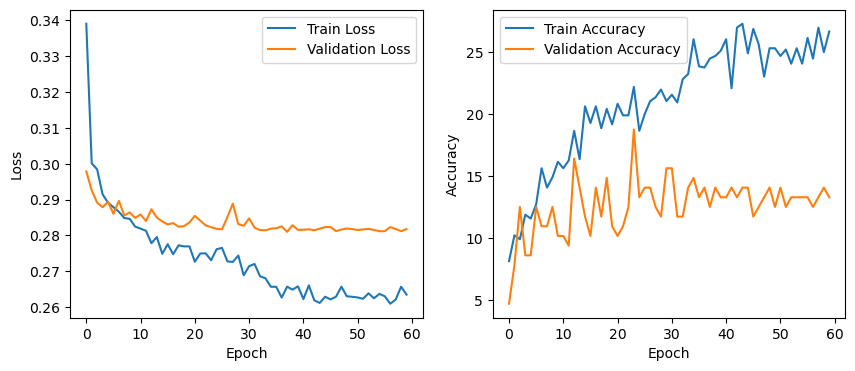

: 

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
#charger le model
model = CustomResNet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load('model_weights_24.pth'))

<All keys matched successfully>

### Matrice de confusion

#### Train data

Train: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


[7, 1, 11, 11, 7, 11, 4, 8, 8, 10, 1, 3, 1, 5, 3, 1, 0, 4, 7, 9, 3, 7, 1, 0, 5, 10, 4, 11, 7, 1, 10, 4, 5, 8, 6, 9, 11, 5, 1, 9, 11, 4, 8, 3, 10, 9, 9, 4, 10, 0, 11, 6, 10, 0, 5, 7, 3, 11, 5, 0, 1, 11, 3, 9, 3, 3, 11, 3, 6, 8, 7, 7, 5, 6, 7, 3, 8, 4, 4, 6, 7, 9, 9, 3, 6, 7, 4, 4, 11, 7, 5, 2, 0, 7, 3, 6, 4, 7, 6, 3, 1, 1, 6, 11, 11, 6, 2, 8, 1, 10, 0, 4, 1, 11, 7, 7, 4, 11, 2, 3, 10, 10, 6, 5, 7, 2, 7, 6, 4, 11, 4, 8, 8, 5, 4, 5, 6, 5, 1, 6, 3, 6, 0, 1, 4, 3, 2, 0, 2, 6, 10, 7, 4, 5, 0, 11, 1, 1, 3, 6, 9, 9, 2, 2, 11, 0, 11, 8, 1, 2, 10, 10, 10, 5, 5, 5, 5, 7, 10, 0, 5, 10, 6, 10, 1, 3, 5, 8, 0, 11, 5, 4, 4, 0, 9, 2, 4, 11, 9, 4, 8, 8, 5, 3, 0, 6, 6, 6, 4, 5, 1, 4, 10, 5, 2, 6, 10, 10, 2, 0, 7, 5, 1, 3, 1, 10, 9, 4, 8, 1, 11, 10, 1, 1, 7, 7, 7, 5, 1, 9, 8, 2, 7, 8, 9, 7, 9, 0, 9, 8, 4, 6, 2, 1, 10, 11, 10, 8, 4, 2, 10, 10, 0, 5, 0, 4, 6, 7, 11, 3, 9, 10, 8, 7, 3, 11, 9, 9, 1, 8, 5, 1, 6, 1, 11, 0, 11, 11, 4, 8, 10, 4, 11, 11, 3, 4, 0, 10, 0, 6, 8, 6, 8, 3, 4, 5, 4, 7, 0, 8, 7, 3, 7, 11

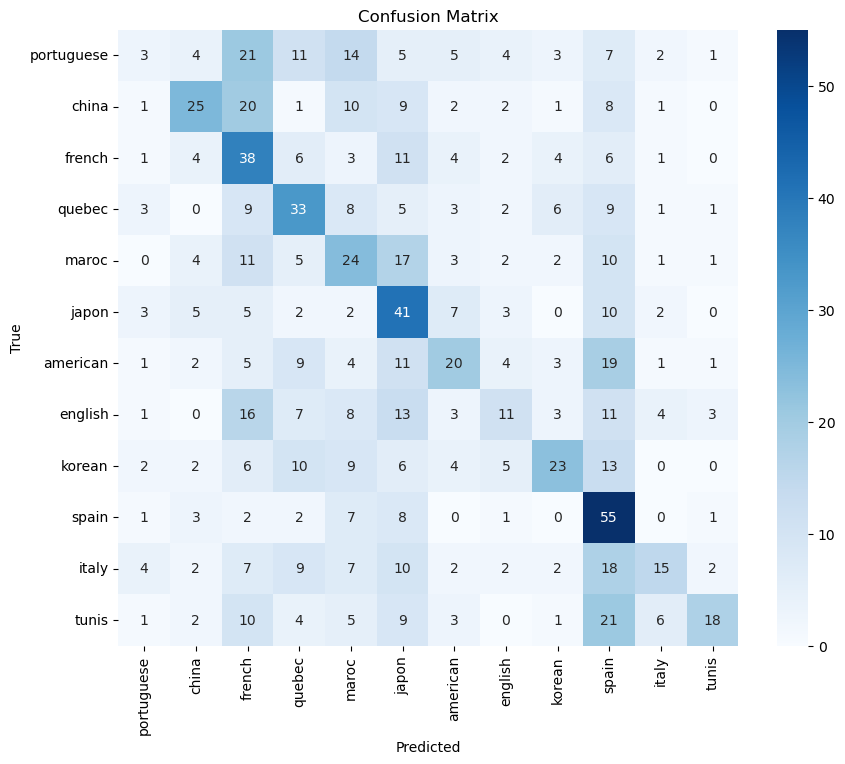

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, labels in tqdm(train_dataloader, desc="Train"):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data.float())
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(y_true)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dict_classes.values(), yticklabels=dict_classes.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

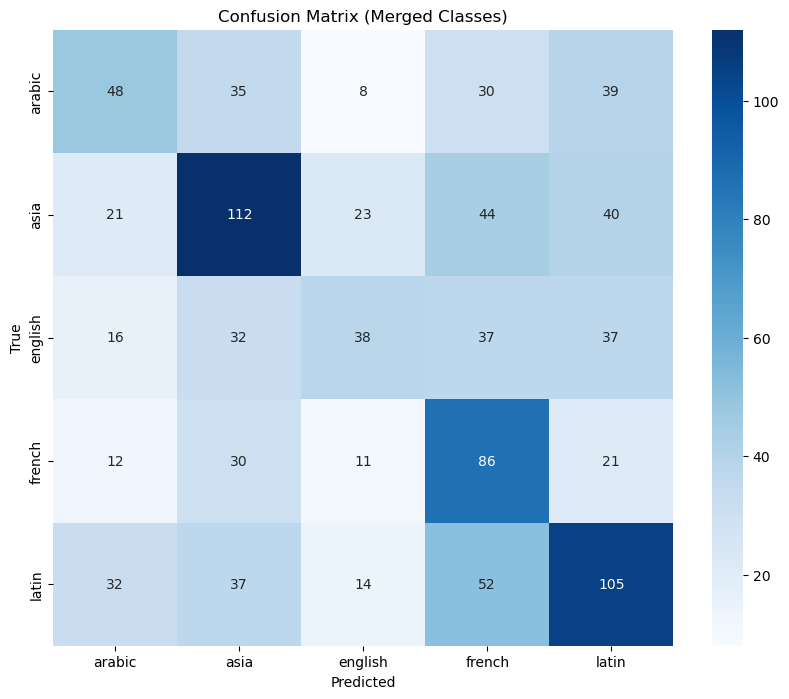

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


merged_classes = {
    "portuguese": "latin",
    "china": "asia",
    "french": "french",
    "quebec": "french",
    "maroc": "arabic",
    "japon": "asia",
    "american": "english",
    "english": "english",
    "korean": "asia",
    "spain": "latin",
    "italy": "latin",
    "tunis": "arabic"
}


y_true_names = [dict_classes[y] for y in y_true]
y_pred_names = [dict_classes[y] for y in y_pred]

y_true_merged = [merged_classes[name] for name in y_true_names]
y_pred_merged = [merged_classes[name] for name in y_pred_names]


le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_merged)
y_pred_encoded = le.transform(y_pred_merged)

unique_classes = le.classes_


cm_merged = confusion_matrix(y_true_encoded, y_pred_encoded)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_merged, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Merged Classes)')
plt.show()

#### Test data

Test: 100%|██████████| 4/4 [00:00<00:00,  9.02it/s]


[5, 1, 5, 7, 10, 0, 6, 3, 5, 6, 0, 10, 1, 8, 10, 3, 3, 2, 4, 8, 10, 6, 8, 6, 11, 3, 11, 9, 8, 1, 2, 4, 8, 3, 8, 9, 4, 9, 7, 2, 3, 3, 11, 4, 11, 6, 7, 5, 4, 11, 6, 9, 0, 6, 4, 10, 7, 1, 0, 7, 4, 1, 5, 11, 5, 0, 2, 2, 8, 11, 4, 2, 1, 7, 5, 7, 2, 3, 8, 7, 10, 6, 1, 7, 10, 11, 9, 1, 7, 0, 11, 9, 11, 10, 0, 6, 10, 3, 5, 9, 2, 0, 8, 1, 2, 5, 1, 3, 0, 9, 9, 5, 6, 10, 4, 9, 8, 0, 4, 2]


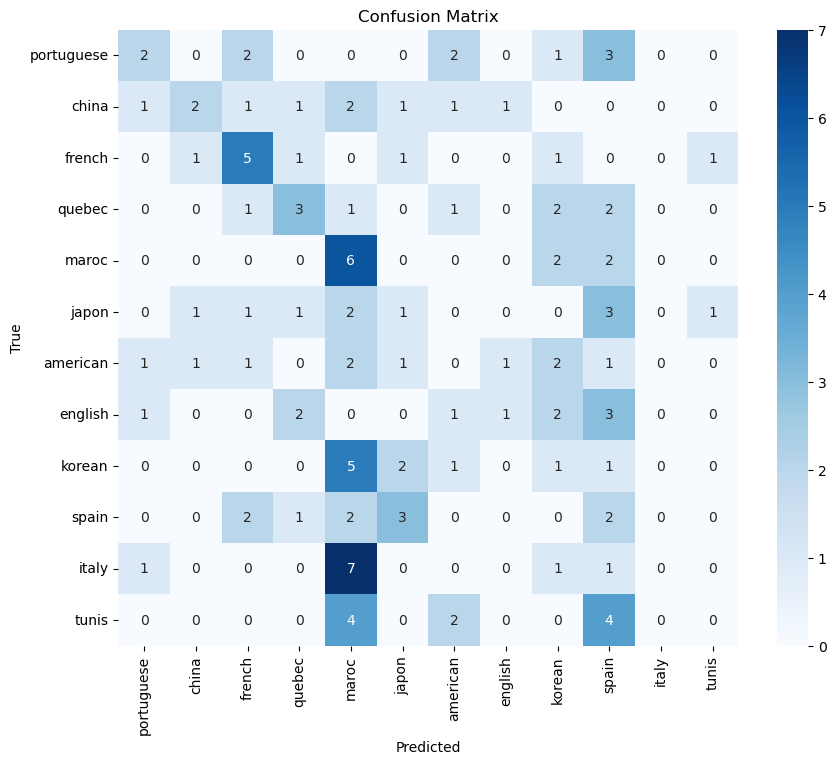

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, labels in tqdm(test_dataloader, desc="Test"):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data.float())
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(y_true)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dict_classes.values(), yticklabels=dict_classes.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


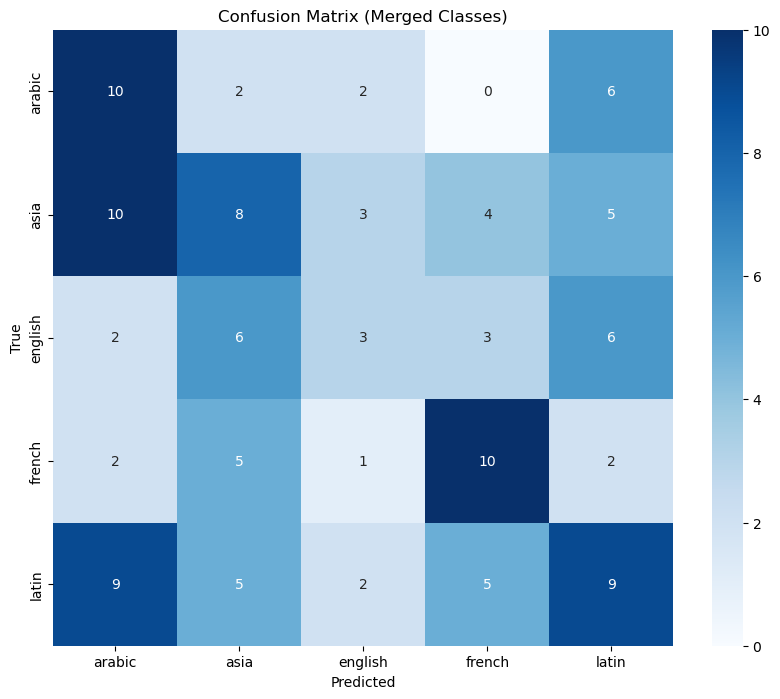

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


merged_classes = {
    "portuguese": "latin",
    "china": "asia",
    "french": "french",
    "quebec": "french",
    "maroc": "arabic",
    "japon": "asia",
    "american": "english",
    "english": "english",
    "korean": "asia",
    "spain": "latin",
    "italy": "latin",
    "tunis": "arabic"
}


y_true_names = [dict_classes[y] for y in y_true]
y_pred_names = [dict_classes[y] for y in y_pred]

y_true_merged = [merged_classes[name] for name in y_true_names]
y_pred_merged = [merged_classes[name] for name in y_pred_names]


le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true_merged)
y_pred_encoded = le.transform(y_pred_merged)

unique_classes = le.classes_


cm_merged = confusion_matrix(y_true_encoded, y_pred_encoded)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_merged, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Merged Classes)')
plt.show()